In [1]:
import pandas as pd
import psycopg2 as ps
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# 1. Creating a PostgreSQL User/Role

First create a user (eg. one named Chimp), with privileges to create databases and other users, by entering the following in a terminal/command line:

```createuser "Chimp" --createrole --createdb -P```

and assigning a password as prompted.

**Note:** This could have been run right in this notebook using ```!createuser "Chimp" --createrole --createdb -P```, but it would've been a challenge responding to the password prompts.

# 2. Creating a Database

To create a database called experiments, either:
- type `createdb experiments` in a terminal/command line, or
- preface the command with '!' and run it in the jupyter notebook, as shown below.

In [2]:
#Creating a database called experiments with the createdb shell command
!createdb experiments

createdb: database creation failed: ERROR:  database "experiments" already exists


# 3. Connecting to a database

In [3]:
#Logging in to database 'experiments' as user 'Chimp'
#Ammend as necessary if using a different role
conn=ps.connect("dbname=experiments user=Chimp password=chimp123 host=localhost ")

#Cursor to perform database operations
cur=conn.cursor()

# 4. Basic Database Operations

In [4]:
#Creating a table called utf8_chars with 2 columns: code_point & character
cur.execute("""
            CREATE TABLE utf8_chars ( 
                    code_point integer, 
                    character text 
                    );
            """)
conn.commit()

In [5]:
#Inserting values into the table
cur.execute("INSERT INTO utf8_chars VALUES (1,'a'), (2, 'b'), (3,'c');")
conn.commit()

In [6]:
#Querying for stored data
cur.execute('SELECT * FROM utf8_chars;')
cur.fetchall()

[(1, 'a'), (2, 'b'), (3, 'c')]

In [7]:
#Iterative insertion
for x in range(33,129):
    cur.execute("INSERT INTO utf8_chars VALUES (%s, %s)",(x,chr(x)))
    
conn.commit()

#Querying for stored data
cur.execute('SELECT * FROM utf8_chars;')
cur.fetchall()  

[(1, 'a'),
 (2, 'b'),
 (3, 'c'),
 (33, '!'),
 (34, '"'),
 (35, '#'),
 (36, '$'),
 (37, '%'),
 (38, '&'),
 (39, "'"),
 (40, '('),
 (41, ')'),
 (42, '*'),
 (43, '+'),
 (44, ','),
 (45, '-'),
 (46, '.'),
 (47, '/'),
 (48, '0'),
 (49, '1'),
 (50, '2'),
 (51, '3'),
 (52, '4'),
 (53, '5'),
 (54, '6'),
 (55, '7'),
 (56, '8'),
 (57, '9'),
 (58, ':'),
 (59, ';'),
 (60, '<'),
 (61, '='),
 (62, '>'),
 (63, '?'),
 (64, '@'),
 (65, 'A'),
 (66, 'B'),
 (67, 'C'),
 (68, 'D'),
 (69, 'E'),
 (70, 'F'),
 (71, 'G'),
 (72, 'H'),
 (73, 'I'),
 (74, 'J'),
 (75, 'K'),
 (76, 'L'),
 (77, 'M'),
 (78, 'N'),
 (79, 'O'),
 (80, 'P'),
 (81, 'Q'),
 (82, 'R'),
 (83, 'S'),
 (84, 'T'),
 (85, 'U'),
 (86, 'V'),
 (87, 'W'),
 (88, 'X'),
 (89, 'Y'),
 (90, 'Z'),
 (91, '['),
 (92, '\\'),
 (93, ']'),
 (94, '^'),
 (95, '_'),
 (96, '`'),
 (97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112,

In [8]:
#Conditional deletion of rows
cur.execute('DELETE FROM utf8_chars WHERE (code_point < 48 OR code_point > 122);')
conn.commit()

cur.execute('SELECT * FROM utf8_chars;')
cur.fetchall()

[(48, '0'),
 (49, '1'),
 (50, '2'),
 (51, '3'),
 (52, '4'),
 (53, '5'),
 (54, '6'),
 (55, '7'),
 (56, '8'),
 (57, '9'),
 (58, ':'),
 (59, ';'),
 (60, '<'),
 (61, '='),
 (62, '>'),
 (63, '?'),
 (64, '@'),
 (65, 'A'),
 (66, 'B'),
 (67, 'C'),
 (68, 'D'),
 (69, 'E'),
 (70, 'F'),
 (71, 'G'),
 (72, 'H'),
 (73, 'I'),
 (74, 'J'),
 (75, 'K'),
 (76, 'L'),
 (77, 'M'),
 (78, 'N'),
 (79, 'O'),
 (80, 'P'),
 (81, 'Q'),
 (82, 'R'),
 (83, 'S'),
 (84, 'T'),
 (85, 'U'),
 (86, 'V'),
 (87, 'W'),
 (88, 'X'),
 (89, 'Y'),
 (90, 'Z'),
 (91, '['),
 (92, '\\'),
 (93, ']'),
 (94, '^'),
 (95, '_'),
 (96, '`'),
 (97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112, 'p'),
 (113, 'q'),
 (114, 'r'),
 (115, 's'),
 (116, 't'),
 (117, 'u'),
 (118, 'v'),
 (119, 'w'),
 (120, 'x'),
 (121, 'y'),
 (122, 'z')]

# 5. Saving & Retrieving Data with Pandas

## 5.1 Saving a Data-frame to the Database

In [9]:
#importing a file as a data-frame
df=pd.read_csv('data.csv', parse_dates=[4]).fillna(0)
df.head()

,Type,Commodity,KGs,Value_of_Goods_Exported,Date
0,Cut-flowers,Anthurium leaves,3769.74,1707653.0,2015-01-25
1,Cut-flowers,Cut foliage,9040.37,4476063.0,2015-01-25
2,Cut-flowers,Fillers,58.00,18938.0,2015-01-25
3,Cut-flowers,Leather leaves/fern,309.72,121856.0,2015-01-25
4,Cut-flowers,Ranunculus,104.00,34827.0,2015-01-25


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
Type                       1800 non-null object
Commodity                  1800 non-null object
KGs                        1800 non-null float64
Value_of_Goods_Exported    1800 non-null float64
Date                       1800 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 70.4+ KB


In [11]:
#Creating the table to hold the data
cur.execute(""" 
            CREATE TABLE exports (
                    Type text,
                    Commodity text,
                    KGs numeric,
                    Value money,
                    Date timestamp
                );
            """)
conn.commit()

In [12]:
#Populating the table
for x in range(len(df)):
    cur.execute('INSERT INTO exports VALUES (%s,%s,%s,%s,%s);',
               tuple(df.iloc[x])) #create a tuple of each row's vales
conn.commit()

## 5.2 Retrieving stored data

In [13]:
#Fetching column names
cur.execute("""SELECT column_name FROM information_schema.columns
                    WHERE table_name='exports';
            """)
cols=cur.fetchall()
cols

[('type',), ('commodity',), ('kgs',), ('value',), ('date',)]

In [14]:
cols=[i[0].title() for i in cols]
cols

['Type', 'Commodity', 'Kgs', 'Value', 'Date']

In [15]:
cur.execute('SELECT * FROM exports;')
stored_data=cur.fetchall()
pd.DataFrame(stored_data, columns=cols)

,Type,Commodity,Kgs,Value,Date
0,Cut-flowers,Anthurium leaves,3769.74,"Ksh1,707,653.00",2015-01-25
1,Cut-flowers,Cut foliage,9040.37,"Ksh4,476,063.00",2015-01-25
2,Cut-flowers,Fillers,58.0,"Ksh18,938.00",2015-01-25
3,Cut-flowers,Leather leaves/fern,309.72,"Ksh121,856.00",2015-01-25
4,Cut-flowers,Ranunculus,104.0,"Ksh34,827.00",2015-01-25
...,...,...,...,...,...
1795,Vegetables,Turnips,63.0,"Ksh42,647.00",2015-12-25
1796,Vegetables,Valore,0.0,Ksh0.00,2015-12-25
1797,Vegetables,Bean processed,770650.88,"Ksh115,660,099.00",2015-12-25
1798,Vegetables,Snow/mangetout,260.0,"Ksh125,520.00",2015-12-25


In [16]:
#Removing rows with zero export amount
cur.execute('DELETE FROM exports where kgs<=0.0;')

#evaluating 'price_per_kg'
cur.execute('SELECT commodity,kgs,value,(value/kgs) AS price_per_kg FROM exports ORDER BY price_per_kg DESC;')
pd.DataFrame(cur.fetchall(), columns=['commodity','kgs','value','price_per_kg'])

,commodity,kgs,value,price_per_kg
0,Geranium cuttings,609.0,"Ksh1,291,615,579.00","Ksh2,120,879.44"
1,Asters,3.0,"Ksh408,938.00","Ksh136,312.67"
2,Geranium cuttings,3045.0,"Ksh265,013,924.00","Ksh87,032.49"
3,Phlox,1910.57,"Ksh153,927,591.00","Ksh80,566.32"
4,Geranium cuttings,4206.74,"Ksh313,812,245.00","Ksh74,597.49"
...,...,...,...,...
1333,Butter nuts,15.0,Ksh32.00,Ksh2.13
1334,Strawberry,2.0,Ksh0.00,Ksh0.00
1335,Carthamus,175.29,Ksh0.00,Ksh0.00
1336,Carthamus,9.04,Ksh0.00,Ksh0.00


In [17]:
#Getting types of commodities
cur.execute('SELECT DISTINCT type FROM exports;')
cur.fetchall()

[('Fruits',), ('Cut-flowers',), ('Vegetables',)]

In [18]:
#Getting names of vegetables exported
cur.execute('SELECT DISTINCT commodity FROM exports WHERE type=\'Vegetables\';')
cur.fetchall()

[('Aloe vera',),
 ('Amaranthus leaves',),
 ('Arrow roots(nduma)',),
 ('Asparagus',),
 ('Aubergines',),
 ('Baby corn',),
 ('Basil',),
 ('Bean processed',),
 ('Beetroot',),
 ('Broccoli',),
 ('Butter nuts',),
 ('Cabbage',),
 ('Carrots',),
 ('Celery',),
 ('Chillies',),
 ('Chillies dried',),
 ('Chives',),
 ('Coriander/dhania',),
 ('Courgettes/zucchine',),
 ('Cucumber',),
 ('Curry leaves/limdi',),
 ('Dill',),
 ('Dudhi',),
 ('Fine beans',),
 ('Garden peas',),
 ('Green maize',),
 ('Gunda',),
 ('Herbs',),
 ('Karella',),
 ('Leeks',),
 ('Matoke',),
 ('Melissa',),
 ('Mixed vegetables',),
 ('Okra',),
 ('Onions',),
 ('Parsley',),
 ('Patra/arrow root leaves',),
 ('Pepper mint',),
 ('Pumpkin',),
 ('Rhubarb',),
 ('Rosemary',),
 ('Runner beans',),
 ('Serenade',),
 ('Snap peas',),
 ('Snow/mangetout',),
 ('Spinach/palak',),
 ('Sugar cane',),
 ('Sweet potatoes',),
 ('Tarragon',),
 ('Thyme',),
 ('Tindori/ivy guard',),
 ('Tomato',),
 ('Turia',),
 ('Turnips',),
 ('Valore',)]

In [19]:
#Getting some aggegates
cur.execute('SELECT commodity,sum(kgs),max(kgs), round(avg(kgs), 4),sum(value) FROM exports GROUP BY commodity;')
pd.DataFrame(cur.fetchall(), columns=['commodity','total_mass(kg)','largest_shipment(kg)','average_mass','total_value']).sort_values(by='largest_shipment(kg)', ascending=False)

,commodity,total_mass(kg),largest_shipment(kg),average_mass,total_value
72,Roses,105164149.83,11049185.48,8763679.1525,"Ksh44,205,855,724.00"
118,Avocado,31225859.63,5302741.82,2602154.9692,"Ksh4,278,199,690.00"
98,Mango,14047648.26,4655128.34,1170637.3550,"Ksh1,612,449,629.00"
101,Mixed vegetables,28129937.97,3565356.17,2344161.4975,"Ksh9,122,920,193.00"
50,Fine beans,23090599.07,3003347.17,1924216.5892,"Ksh7,109,839,896.00"
...,...,...,...,...,...
26,Dried carnations,6.96,6.96,6.9600,"Ksh5,181.00"
78,Melissa,6.0,6.0,6.0000,"Ksh2,724.00"
94,Celery,5.0,5.0,5.0000,Ksh30.00
121,Gerbera,1.70,1.23,0.8500,Ksh369.00


In [20]:
conn.commit()

## 5.3 Basic Data Wrangling

In [21]:
cur.execute('SELECT * FROM exports;')
df2=pd.DataFrame(cur.fetchall(), columns=cols)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 5 columns):
Type         1338 non-null object
Commodity    1338 non-null object
Kgs          1338 non-null object
Value        1338 non-null object
Date         1338 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 52.4+ KB


In [22]:
#Restoring 'Kgs' column to numeric data type
df2.Kgs=[float(x) for x in df2.Kgs]

#Removing currency label and commas, then restoring 'Value' column to numeric data type
df2.Value=[float(x.strip('Ksh').replace(',','')) for x in df2.Value]

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 5 columns):
Type         1338 non-null object
Commodity    1338 non-null object
Kgs          1338 non-null float64
Value        1338 non-null float64
Date         1338 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 52.4+ KB


In [23]:
df2.head()

,Type,Commodity,Kgs,Value,Date
0,Cut-flowers,Anthurium leaves,3769.74,1707653.0,2015-01-25
1,Cut-flowers,Cut foliage,9040.37,4476063.0,2015-01-25
2,Cut-flowers,Fillers,58.00,18938.0,2015-01-25
3,Cut-flowers,Leather leaves/fern,309.72,121856.0,2015-01-25
4,Cut-flowers,Ranunculus,104.00,34827.0,2015-01-25


## 5.4 Basic Visual Analysis

Text(0.5, 1.0, 'Most Sold Commodities - By Frequency')

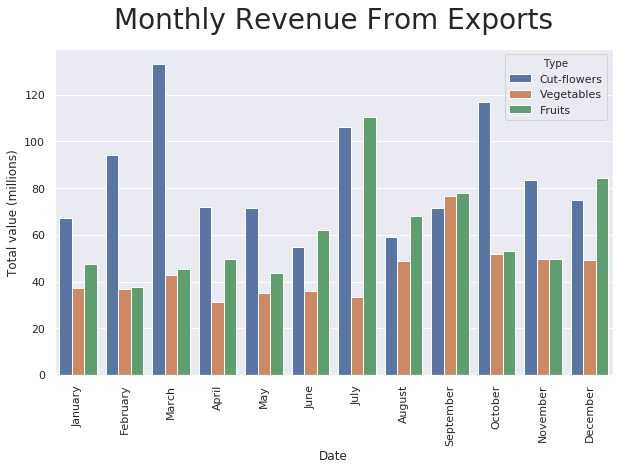

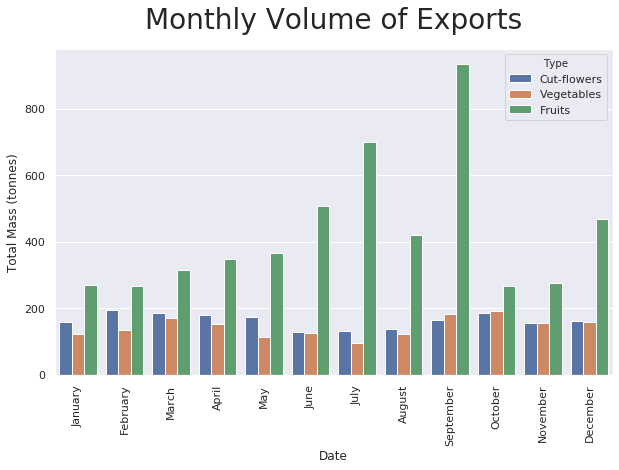

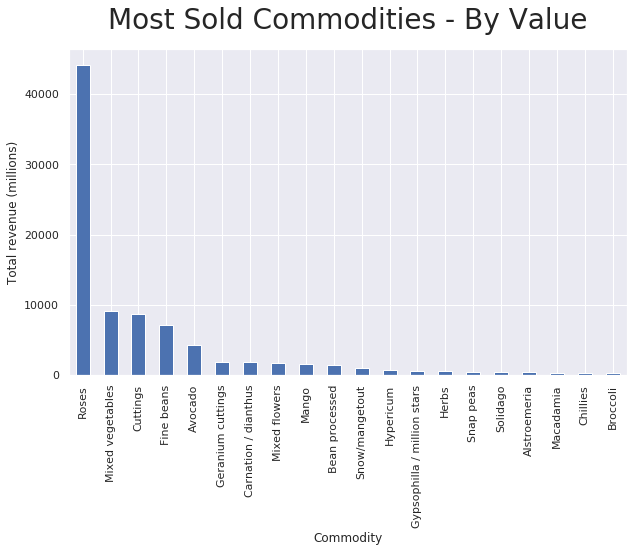

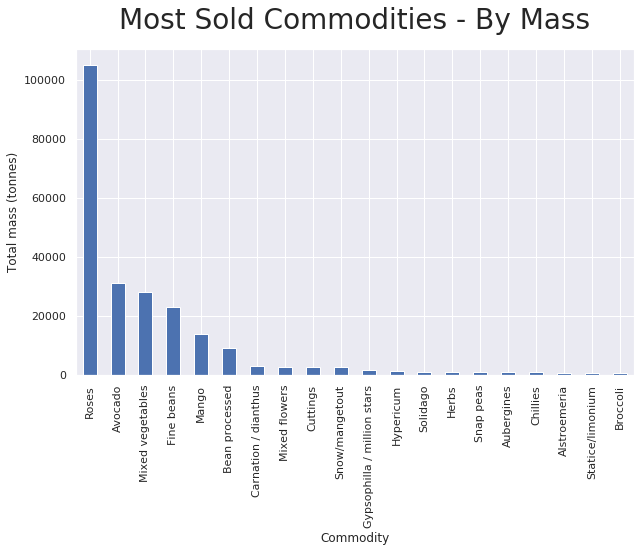

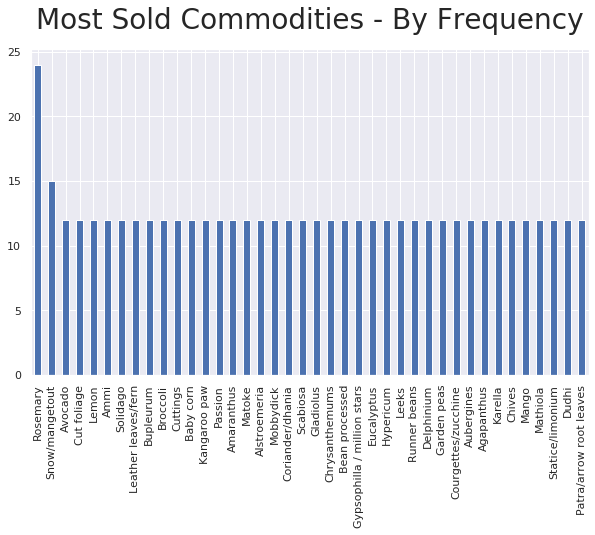

In [24]:
#Monthly Revenue From Exports
plt.figure(figsize=(10,6))
import calendar
sns.barplot(x=df2.Date.dt.month_name(), y=df2.Value/(10**6), hue=df2.Type, ci=None, order=[calendar.month_name[x] for x in range(1,13) ])
plt.xticks(rotation=90)
plt.ylabel('Total value (millions)')
plt.title('Monthly Revenue From Exports',fontsize=28,fontweight=550, pad=20)

#Monthly Volume of Exports
plt.figure(figsize=(10,6))
sns.barplot(x=df2.Date.dt.month_name(), y=df2.Kgs/(1000),hue=df2.Type, ci=None, order=[calendar.month_name[x] for x in range(1,13) ])
plt.xticks(rotation=90)
plt.ylabel('Total Mass (tonnes)')
plt.title('Monthly Volume of Exports',fontsize=28,fontweight=550, pad=20)

#Most Sold Commodities - By Value
totals=df2[['Commodity','Value','Kgs']].groupby('Commodity').agg('sum')
plt.figure(figsize=(10,6))
(totals.Value.sort_values(ascending=False).nlargest(20)/(10**6)).plot(kind='bar')
plt.xticks(rotation=90)
plt.ylabel('Total revenue (millions)')
plt.title('Most Sold Commodities - By Value',fontsize=28,fontweight=550, pad=20)


#Most Sold Commodities - By Mass
plt.figure(figsize=(10,6))
(totals.Kgs.sort_values(ascending=False).nlargest(20)/(1000)).plot(kind='bar')
plt.xticks(rotation=90)
plt.ylabel('Total mass (tonnes)')
plt.title('Most Sold Commodities - By Mass',fontsize=28,fontweight=550, pad=20)

#Most Sold Commodities - By Frequency
plt.figure(figsize=(10,6))
df2.Commodity.value_counts().nlargest(40).plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Most Sold Commodities - By Frequency',fontsize=28,fontweight=550, pad=20)

# 6. Creating Other Users

In [25]:
#Creating user Owl who can create databases and other users
cur.execute('CREATE USER "Owl" CREATEROLE CREATEDB PASSWORD \'owl123\';')

#Creating user Gorilla who can only create databases
cur.execute('CREATE USER "Gorilla" CREATEDB;')

conn.commit()

In [26]:
#Checking if the users were created
cur.execute('GRANT "Gorilla","Owl" to "Chimp";') # assigning the roles to Chimp
cur.execute("SELECT role_name FROM information_schema.enabled_roles;")
cur.fetchall()

[('Chimp',), ('Owl',), ('Gorilla',)]

# 7. Deleting Created Objects & Users

In [27]:
#Deleting created tables
cur.execute('DROP TABLE utf8_chars;')
cur.execute('DROP TABLE exports;')
conn.commit()

In [28]:
#Removing created users
cur.execute('DROP ROLE "Owl"')
cur.execute('DROP ROLE "Gorilla"')
conn.commit()

In [29]:
#Removing everything owned by Chimp
cur.execute('DROP OWNED BY "Chimp";')
conn.commit()

In [30]:
#Closing connection to database
cur.close()
conn.close()

In [31]:
#Deleting database 'experiments'
!dropdb experiments

In [32]:
#Deleting user Chimp
!dropuser 'Chimp'